In [1]:
import argparse
import copy
import math
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.io import read_image

from tqdm import tqdm
from einops import rearrange, repeat
from omegaconf import OmegaConf
from functools import partial

# diffusers
import requests
from io import BytesIO
import diffusers
from diffusers import DDIMScheduler
from diffusers import StableDiffusionInpaintPipeline

from masactrl.diffuser_utils import McaPipeline_generation, LocalBlend
from masactrl.masactrl_utils import regiter_attention_editor_diffusers
from masactrl.masactrl_p2p import McaControlGeneration

from torchvision.utils import save_image
from torchvision.io import read_image
from torchvision.ops import box_convert
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from pytorch_lightning import seed_everything

import PIL
from PIL import Image, ImageDraw, ImageFont
import random
from torchvision import transforms

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor 

from huggingface_hub import hf_hub_download

import argparse

/data2/anaconda3/envs/mulcolla/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### load stable diffusion

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_path = '/data4/yanghan/Generation/HuggingFace/stabilityai/SG161222/Realistic_Vision_V4.0_noVAE'
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
sd_model = McaPipeline_generation.from_pretrained(model_path, scheduler=scheduler).to(device)
tokenizer = sd_model.tokenizer

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  6.43it/s]
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.29.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request for the `scheduler/scheduler_config.json` file


## generate condition and source

input text embeddings : torch.Size([1, 77, 768])
latents shape:  torch.Size([1, 4, 64, 64])
Valid timesteps:  tensor([  1,  21,  41,  61,  81, 101, 121, 141, 161, 181, 201, 221, 241, 261,
        281, 301, 321, 341, 361, 381, 401, 421, 441, 461, 481, 501, 521, 541,
        561, 581, 601, 621, 641, 661, 681, 701, 721, 741, 761, 781, 801, 821,
        841, 861, 881, 901, 921, 941, 961, 981])


DDIM Inversion: 100%|██████████| 50/50 [00:07<00:00,  6.57it/s]


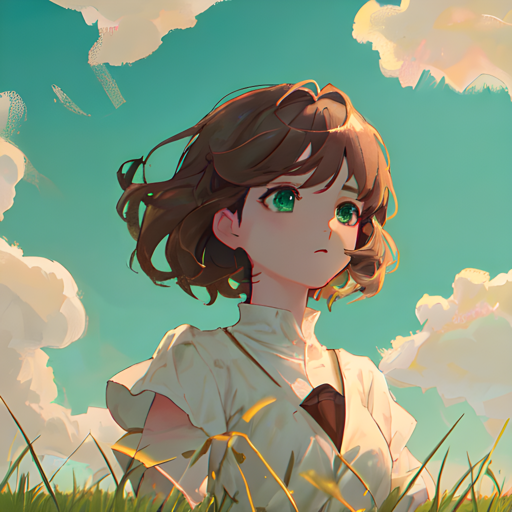

In [3]:
def load_image_k(image_path, device):
    image = read_image(image_path)
    image = image[:3].unsqueeze_(0).float() / 127.5 - 1.  # [-1, 1]
    image = F.interpolate(image, (512, 512))
    image = image.to(device)
    return image

# ref image
ref_prompt = ""
num_inference_steps = 50
REF_IMAGE_PATH = 'data/image1.png'
ref_image = load_image_k(REF_IMAGE_PATH, device)

# invert the ref image
ref_start_code, ref_latents_list = sd_model.invert(ref_image,
                                        ref_prompt,
                                        guidance_scale=7.5,
                                        num_inference_steps=num_inference_steps,
                                        return_intermediates=True)
                                        
pil_image = transforms.ToPILImage()(read_image(REF_IMAGE_PATH))
pil_image.resize((512,512))

## run grounded sam

In [4]:
args = SLConfig.fromfile('/data4/yanghan/Generation/HuggingFace/Shilongliu/GroundingDINO/GroundingDINO_SwinB.cfg.py') 
groundingdino_model = build_model(args)
checkpoint = torch.load('/data4/yanghan/Generation/HuggingFace/Shilongliu/GroundingDINO/groundingdino_swinb_cogcoor.pth', map_location='cpu')
groundingdino_model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
groundingdino_model.eval()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sam_checkpoint = '/data4/yanghan/Generation/MCA-Ctrl/MCA-Ctrl_git/sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

final text_encoder_type: bert-base-uncased


In [5]:
def load_image(image):
    transform = T.Compose(
        [
            T.RandomResize([400], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image_transformed, _ = transform(image, None)
    return image_transformed

TEXT_PROMPT = 'anime'
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25

ref_image_np = np.asarray(ref_image.squeeze().cpu())
ref_image_np = ref_image_np.transpose(1,2,0)
ref_image_np = (ref_image_np * 0.5 + 0.5) * 255
ref_image_I = Image.fromarray(np.uint8(ref_image_np))
trans_ref = load_image(ref_image_I)

ref_boxes, ref_logits, ref_phrases = predict(
    model=groundingdino_model, 
    image=trans_ref, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD,
    device=DEVICE
)
ref_annotated_frame = annotate(image_source=ref_image_np, boxes=ref_boxes, logits=ref_logits, phrases=ref_phrases)
ref_annotated_frame = ref_annotated_frame[...,::-1] # BGR to RGB

sam_predictor.set_image(np.uint8(ref_image_np))
# box: normalized box xywh -> unnormalized xyxy
H, W, _ = ref_image_np.shape
ref_boxes_xyxy = box_ops.box_cxcywh_to_xyxy(ref_boxes) * torch.Tensor([W, H, W, H])
ref_transformed_boxes = sam_predictor.transform.apply_boxes_torch(ref_boxes_xyxy, ref_image_np.shape[:2]).to(DEVICE)
ref_masks, _, _ = sam_predictor.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes = ref_transformed_boxes,
            multimask_output = False,
        )
ref_mask = torch.where(ref_masks[0][0], 1, 0)

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


## inference the synthesized image

In [11]:
prompt = 'A anime in a garden with flowers'
prompts = [prompt, prompt]
self_replace_steps = 0.1
SAQI_st = 0
START_LAYPER = 0
END_LAYPER = 16
START_STEP = 4
END_STEP = 50
negative_prompt = "over-exposure, under-exposure, saturated, duplicate, out of frame, lowres, cropped, worst quality, low quality, jpeg artifacts, morbid, mutilated, out of frame, ugly, bad anatomy, bad proportions, deformed, blurry, duplicate"

Seed set to 3753


McaControlGeneration at denoising steps:  [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
McaControlGeneration at U-Net layers:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
input text embeddings : torch.Size([2, 77, 768])
latents shape:  torch.Size([2, 4, 64, 64])


DDIM Sampler: 100%|██████████| 50/50 [00:35<00:00,  1.43it/s]


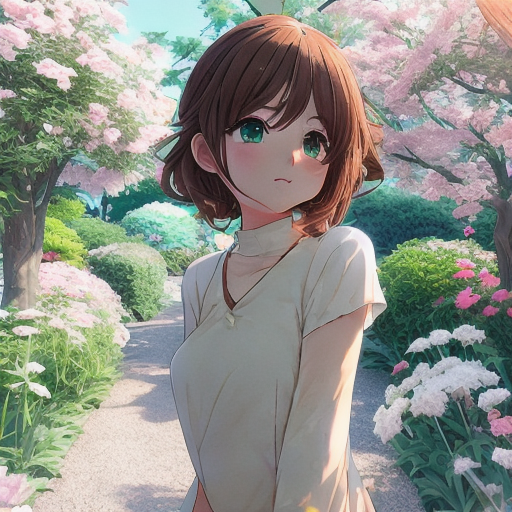

In [12]:
seed = 3753
seed_everything(seed)
editor = McaControlGeneration([2], self_replace_steps, SAQI_st,START_STEP, END_STEP, START_LAYPER, END_LAYPER, mask_r=ref_mask.float())
regiter_attention_editor_diffusers(sd_model, editor)

image_masactrl = sd_model(prompts,
                        latents=None,
                        num_inference_steps=num_inference_steps,
                        guidance_scale=7.5,
                        ref_intermediate_latents=ref_latents_list,
                        neg_prompt = negative_prompt,
                        mask_r = ref_mask.float())

pil_image = transforms.ToPILImage()(image_masactrl[-1:].squeeze())
pil_image